In [1]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import KFold

from data_loader import load_data, get_balanced_data, normalize_features

# import wandb
# wandb.init(project='gene')

data = load_data()
X_balanced, y_balanced = get_balanced_data(data)
FEATURE_TYPES = ['mcg', 'atac', 'hic', 'genebody']
for k, v in X_balanced.items():
    print(k, len(v))
# y_balanced = y_balanced[:, 2]
# print('zero:', (y_balanced == 0).sum(), 'non-zero:', (y_balanced != 0).sum())

Processed mcg data
Processed genebody data
Processed atac data
Processed hic data
zero: 4115, non-zero: 1431
mcg 2146
genebody 2146
atac 2146
hic 2146


In [2]:
# check how many  0 , -1 and 1 in y_balanced
print('y_balanced 0:', np.sum(y_balanced == 0))
print('y_balanced -1:', np.sum(y_balanced == -1))
print('y_balanced 1:', np.sum(y_balanced == 1))


y_balanced 0: 715
y_balanced -1: 874
y_balanced 1: 557


Normalizing mcg features
Normalizing genebody features
Normalizing atac features
Normalizing hic features


In [3]:
# 63%
HIDDEN_DIM = 128
NUM_LAYERS = 4  
NUM_HEADS = 4
DROPOUT = 0.1
LR = 1e-3
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 50
BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 4
# NUM_HEADS = 8
# DROPOUT = 0.0
# LR = 0.03
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 20
# BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 1
# NUM_HEADS = 1
# DROPOUT = 0.3
# LR = 1e-4
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 200
# BATCH_SIZE = 16


class FourHeadTransformerModel(nn.Module):
    def __init__(self, mcg_input_dim, atac_input_dim, hic_input_dim, genebody_input_dim, hidden_dim, output_dim, num_layers=2, num_heads=1, dropout=0.1):
        super(FourHeadTransformerModel, self).__init__()
        self.mcg_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.atac_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.hic_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.genebody_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.combined_cls_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))
        self.mcg_embedding = nn.Linear(mcg_input_dim, hidden_dim)
        self.atac_embedding = nn.Linear(atac_input_dim, hidden_dim)
        self.hic_embedding = nn.Linear(hic_input_dim, hidden_dim)
        self.genebody_embedding = nn.Linear(genebody_input_dim, hidden_dim)

        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim*4, dropout=dropout, batch_first=True, norm_first=True)
        self.mcg_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.atac_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.hic_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        self.genebody_transformer = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Use self-attention mechanism to combine the outputs of the four heads
        self.weight_vector = nn.Parameter(torch.randn(4, 1))
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout))
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Parameter):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)


        

    def forward(self, mcg_x, mcg_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask):
        mcg_x = self.mcg_embedding(mcg_x)
        atac_x = self.atac_embedding(atac_x)
        hic_x = self.hic_embedding(hic_x)
        genebody_x = self.genebody_embedding(genebody_x)
        # Add cls embedding, so that we can take the first output as the representation of the sequence
        mcg_cls_embedding = self.mcg_cls_embedding.repeat(mcg_x.size(0), 1, 1)
        atac_cls_embedding = self.atac_cls_embedding.repeat(atac_x.size(0), 1, 1)
        hic_cls_embedding = self.hic_cls_embedding.repeat(hic_x.size(0), 1, 1)
        genebody_cls_embedding = self.genebody_cls_embedding.repeat(genebody_x.size(0), 1, 1)

        mcg_x = torch.cat((mcg_cls_embedding, mcg_x), dim=1)
        atac_x = torch.cat((atac_cls_embedding, atac_x), dim=1)
        hic_x = torch.cat((hic_cls_embedding, hic_x), dim=1)
        genebody_x = torch.cat((genebody_cls_embedding, genebody_x), dim=1)

        mcg_mask = torch.cat((torch.ones(mcg_mask.size(0), 1), mcg_mask), dim=1)
        atac_mask = torch.cat((torch.ones(atac_mask.size(0), 1), atac_mask), dim=1)
        hic_mask = torch.cat((torch.ones(hic_mask.size(0), 1), hic_mask), dim=1)
        genebody_mask = torch.cat((torch.ones(genebody_mask.size(0), 1), genebody_mask), dim=1)

        mcg_x = self.mcg_transformer(mcg_x, src_key_padding_mask=~mcg_mask.bool())
        atac_x = self.atac_transformer(atac_x, src_key_padding_mask=~atac_mask.bool())
        hic_x = self.hic_transformer(hic_x, src_key_padding_mask=~hic_mask.bool())
        genebody_x = self.genebody_transformer(genebody_x, src_key_padding_mask=~genebody_mask.bool())
        
        # Pooling, we should not use average pooling since the sequence length is also important
        mcg_x = mcg_x[:, 0, :]
        atac_x = atac_x[:, 0, :]
        hic_x = hic_x[:, 0, :]
        genebody_x = genebody_x[:, 0, :]

        # Combine the output of four heads into a sequence
        combined_x = torch.stack((mcg_x, atac_x, hic_x, genebody_x), dim=2) # (batch_size, hidden_dim, 4)
        combined_x  = torch.matmul(combined_x, F.softmax(self.weight_vector, dim=0)).squeeze(-1) # (batch_size, hidden_dim, 1)
        output = self.linear(combined_x) + combined_x
        output = self.classifier(combined_x)
        return output

class CombinedGeneDataset(Dataset):
    def __init__(self, mcg_data, atac_data, hic_data, genebody_data, labels):
        self.mcg_data = mcg_data
        self.atac_data = atac_data
        self.hic_data = hic_data
        self.genebody_data = genebody_data
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        mcg_gene_data = torch.FloatTensor(self.mcg_data[idx])
        atac_gene_data = torch.FloatTensor(self.atac_data[idx])
        hic_gene_data = torch.FloatTensor(self.hic_data[idx])
        genebody_gene_data = torch.FloatTensor(self.genebody_data[idx])
        label = torch.LongTensor([self.labels[idx] + 1])  # Add 1 to shift labels to 0, 1, 2
        mcg_mask = torch.ones(len(mcg_gene_data))
        atac_mask = torch.ones(len(atac_gene_data))
        hic_mask = torch.ones(len(hic_gene_data))
        genebody_mask = torch.ones(len(genebody_gene_data))
        return mcg_gene_data, atac_gene_data, hic_gene_data, genebody_gene_data, label, mcg_mask, atac_mask, hic_mask, genebody_mask

def combined_collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    mcg_sequences, atac_sequences, hic_sequences, genebody_sequences, labels, mcg_masks, atac_masks, hic_masks, genebody_masks = zip(*batch)
    
    mcg_lengths = [len(seq) for seq in mcg_sequences]
    atac_lengths = [len(seq) for seq in atac_sequences]
    hic_lengths = [len(seq) for seq in hic_sequences]
    genebody_lengths = [len(seq) for seq in genebody_sequences]
    mcg_max_len = max(mcg_lengths)
    atac_max_len = max(atac_lengths)
    hic_max_len = max(hic_lengths)
    genebody_max_len = max(genebody_lengths)
    
    padded_mcg_seqs = torch.zeros(len(mcg_sequences), mcg_max_len, mcg_sequences[0].size(1))
    padded_atac_seqs = torch.zeros(len(atac_sequences), atac_max_len, atac_sequences[0].size(1))
    padded_hic_seqs = torch.zeros(len(hic_sequences), hic_max_len, hic_sequences[0].size(1))
    padded_genebody_seqs = torch.zeros(len(genebody_sequences), genebody_max_len, genebody_sequences[0].size(1))
    padded_mcg_masks = torch.zeros(len(mcg_sequences), mcg_max_len)
    padded_atac_masks = torch.zeros(len(atac_sequences), atac_max_len)
    padded_hic_masks = torch.zeros(len(hic_sequences), hic_max_len)
    padded_genebody_masks = torch.zeros(len(genebody_sequences), genebody_max_len)
    
    for i, (mcg_seq, atac_seq, hic_seq, genebody_seq, mcg_length, atac_length, hic_length, genebody_length) in enumerate(zip(mcg_sequences, atac_sequences, hic_sequences, genebody_sequences, mcg_lengths, atac_lengths, hic_lengths, genebody_lengths)):
        padded_mcg_seqs[i, :mcg_length] = mcg_seq
        padded_atac_seqs[i, :atac_length] = atac_seq
        padded_hic_seqs[i, :hic_length] = hic_seq
        padded_genebody_seqs[i, :genebody_length] = genebody_seq
        padded_mcg_masks[i, :mcg_length] = 1
        padded_atac_masks[i, :atac_length] = 1
        padded_hic_masks[i, :hic_length] = 1
        padded_genebody_masks[i, :genebody_length] = 1
    
    return padded_mcg_seqs, padded_atac_seqs, padded_hic_seqs, padded_genebody_seqs, torch.cat(labels), padded_mcg_masks, padded_atac_masks, padded_hic_masks, padded_genebody_masks

def train_combined_model(X_train_mcg, X_train_atac, X_train_hic, X_train_genebody, y_train, X_test_mcg, X_test_atac, X_test_hic, X_test_genebody, y_test, exp_name, fold_idx):
    #wandb.init(project='gene', group=exp_name, name=f'fold-{fold_idx}')
    mcg_input_dim = len(X_train_mcg[0][0])
    atac_input_dim = len(X_train_atac[0][0])
    hic_input_dim = len(X_train_hic[0][0])
    genebody_input_dim = len(X_train_genebody[0][0])
    
    train_dataset = CombinedGeneDataset(X_train_mcg, X_train_atac, X_train_hic, X_train_genebody, y_train)
    test_dataset = CombinedGeneDataset(X_test_mcg, X_test_atac, X_test_hic, X_test_genebody, y_test)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=combined_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=combined_collate_fn)

    model = FourHeadTransformerModel(mcg_input_dim, atac_input_dim, hic_input_dim, genebody_input_dim, HIDDEN_DIM, OUTPUT_DIM, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT)

    from sklearn.utils.class_weight import compute_class_weight

    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weights = torch.FloatTensor(class_weights)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=LR)
    # lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.0001)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
    lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=NUM_EPOCHS)

    # Create the OneCycleLR scheduler
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=NUM_EPOCHS,
    #                           pct_start=0.8, anneal_strategy='cos',
    #                           cycle_momentum=False, div_factor=5.0,
    #                           final_div_factor=10.0)

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        for mcg_x, atac_x, hic_x, genebody_x, batch_y, mcg_mask, atac_mask, hic_mask, genebody_mask in train_loader:
            optimizer.zero_grad()
            outputs = model(mcg_x, mcg_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask)
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
            train_total += batch_y.size(0)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for mcg_x, atac_x, hic_x, genebody_x, batch_y, mcg_mask, atac_mask, hic_mask, genebody_mask in test_loader:
                outputs = model(mcg_x, mcg_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.squeeze()).sum().item()
        
        accuracy = correct / total
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_correct/train_total:.4f}, Test Accuracy: {accuracy:.4f}')
        #wandb.log({'epoch': epoch, 'LR': optimizer.param_groups[0]['lr'], 'train_loss': total_loss/len(train_loader), 'train_accuracy': train_correct/train_total, 'test_accuracy': accuracy})

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for mcg_x, atac_x, hic_x, genebody_x, batch_y, mcg_mask, atac_mask, hic_mask, genebody_mask in test_loader:
            outputs = model(mcg_x, mcg_mask, atac_x, atac_mask, hic_x, hic_mask, genebody_x, genebody_mask)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_accuracy = sum(np.array(all_predictions) == np.array(all_labels).squeeze()) / len(all_labels)
    print(f'Final Test Accuracy: {final_accuracy:.4f}')
    return final_accuracy, all_predictions, all_labels, model

In [4]:
import time
exp_name = f'four-head-{time.strftime("%Y%m%d-%H%M%S")}'

# wandb.config.update({
#     'hidden_dim': HIDDEN_DIM,
#     'num_layers': NUM_LAYERS,
#     'num_heads': NUM_HEADS,
#     'dropout': DROPOUT,
#     'lr': LR,
#     'output_dim': OUTPUT_DIM,
#     'num_epochs': NUM_EPOCHS
# })


kf = KFold(n_splits=5, shuffle=True, random_state=25)
accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(X_balanced['mcg'])):
    X_train_mcg, X_test_mcg = [X_balanced['mcg'][i] for i in train_index], [X_balanced['mcg'][i] for i in test_index]
    X_train_atac, X_test_atac = [X_balanced['atac'][i] for i in train_index], [X_balanced['atac'][i] for i in test_index]
    X_train_hic, X_test_hic = [X_balanced['hic'][i] for i in train_index], [X_balanced['hic'][i] for i in test_index]
    X_train_genebody, X_test_genebody = [X_balanced['genebody'][i] for i in train_index], [X_balanced['genebody'][i] for i in test_index]
    y_train, y_test = [y_balanced[i] for i in train_index], [y_balanced[i] for i in test_index]

    
    X_train_mcg_normalized, X_test_mcg_normalized = normalize_features(X_train_mcg, X_test_mcg)
    X_train_atac_normalized, X_test_atac_normalized = normalize_features(X_train_atac, X_test_atac)
    X_train_hic_normalized, X_test_hic_normalized = normalize_features(X_train_hic, X_test_hic)
    X_train_genebody_normalized, X_test_genebody_normalized = normalize_features(X_train_genebody, X_test_genebody)
    
    accuracies.append(train_combined_model(X_train_mcg_normalized, X_train_atac_normalized, X_train_hic_normalized, X_train_genebody_normalized, y_train, 
                                           X_test_mcg_normalized, X_test_atac_normalized, X_test_hic_normalized, X_test_genebody_normalized, y_test, exp_name=exp_name, fold_idx=i))
    # acc, preds, labels, model = train_combined_model(X_train_mcg_normalized, X_train_atac_normalized, X_train_hic_normalized, X_train_genebody_normalized, y_train,
    #                                           X_test_mcg_normalized, X_test_atac_normalized, X_test_hic_normalized, X_test_genebody_normalized, y_test, exp_name=exp_name, fold_idx=i)
    break

# print(f'Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}')

/opt/conda/envs/ml/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/var/tmp/ipykernel_44788/129376214.py:129: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  label = torch.LongTensor([self.labels[idx] + 1])  # Add 1 to shift labels to 0, 1, 2


Epoch [1/50], Train Loss: 1.1985, Train Accuracy: 0.4172, Test Accuracy: 0.4837
Epoch [2/50], Train Loss: 1.0115, Train Accuracy: 0.5157, Test Accuracy: 0.5233
Epoch [3/50], Train Loss: 0.9629, Train Accuracy: 0.5402, Test Accuracy: 0.6442
Epoch [4/50], Train Loss: 0.9118, Train Accuracy: 0.5600, Test Accuracy: 0.6209
Epoch [5/50], Train Loss: 1.0182, Train Accuracy: 0.5379, Test Accuracy: 0.4512
Epoch [6/50], Train Loss: 0.9799, Train Accuracy: 0.5431, Test Accuracy: 0.6419
Epoch [7/50], Train Loss: 0.8752, Train Accuracy: 0.5857, Test Accuracy: 0.6023
Epoch [8/50], Train Loss: 0.9205, Train Accuracy: 0.5699, Test Accuracy: 0.6558
Epoch [9/50], Train Loss: 0.8550, Train Accuracy: 0.5874, Test Accuracy: 0.5302
Epoch [10/50], Train Loss: 0.8948, Train Accuracy: 0.5798, Test Accuracy: 0.4674
Epoch [11/50], Train Loss: 0.9474, Train Accuracy: 0.5659, Test Accuracy: 0.6233
Epoch [12/50], Train Loss: 0.8905, Train Accuracy: 0.5967, Test Accuracy: 0.5930
Epoch [13/50], Train Loss: 0.8270, Tr

In [5]:
for i, (acc, preds, labels, model) in enumerate(accuracies):
    print(f'Fold {i}: {acc:.4f}')

Fold 0: 0.6605


# plot

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
_labels = [i[0] for i in labels]

result = pd.DataFrame([np.array(_labels) - 1, np.array(preds) - 1 ]).T
result.columns = ['true', 'pred']

<Axes: >

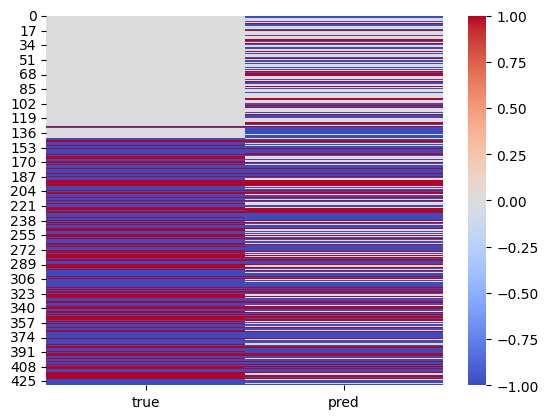

In [10]:
sns.heatmap(result, cmap = 'coolwarm')

In [11]:
result['predict_true'] = result['true'] == result['pred']

In [12]:

toplot= result.groupby('true')['predict_true'].mean()

In [13]:
toplot

true
-1    0.789157
 0    0.525180
 1    0.640000
Name: predict_true, dtype: float64

/var/tmp/ipykernel_44788/1903490480.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['down',  'non-age-deg', 'up',])


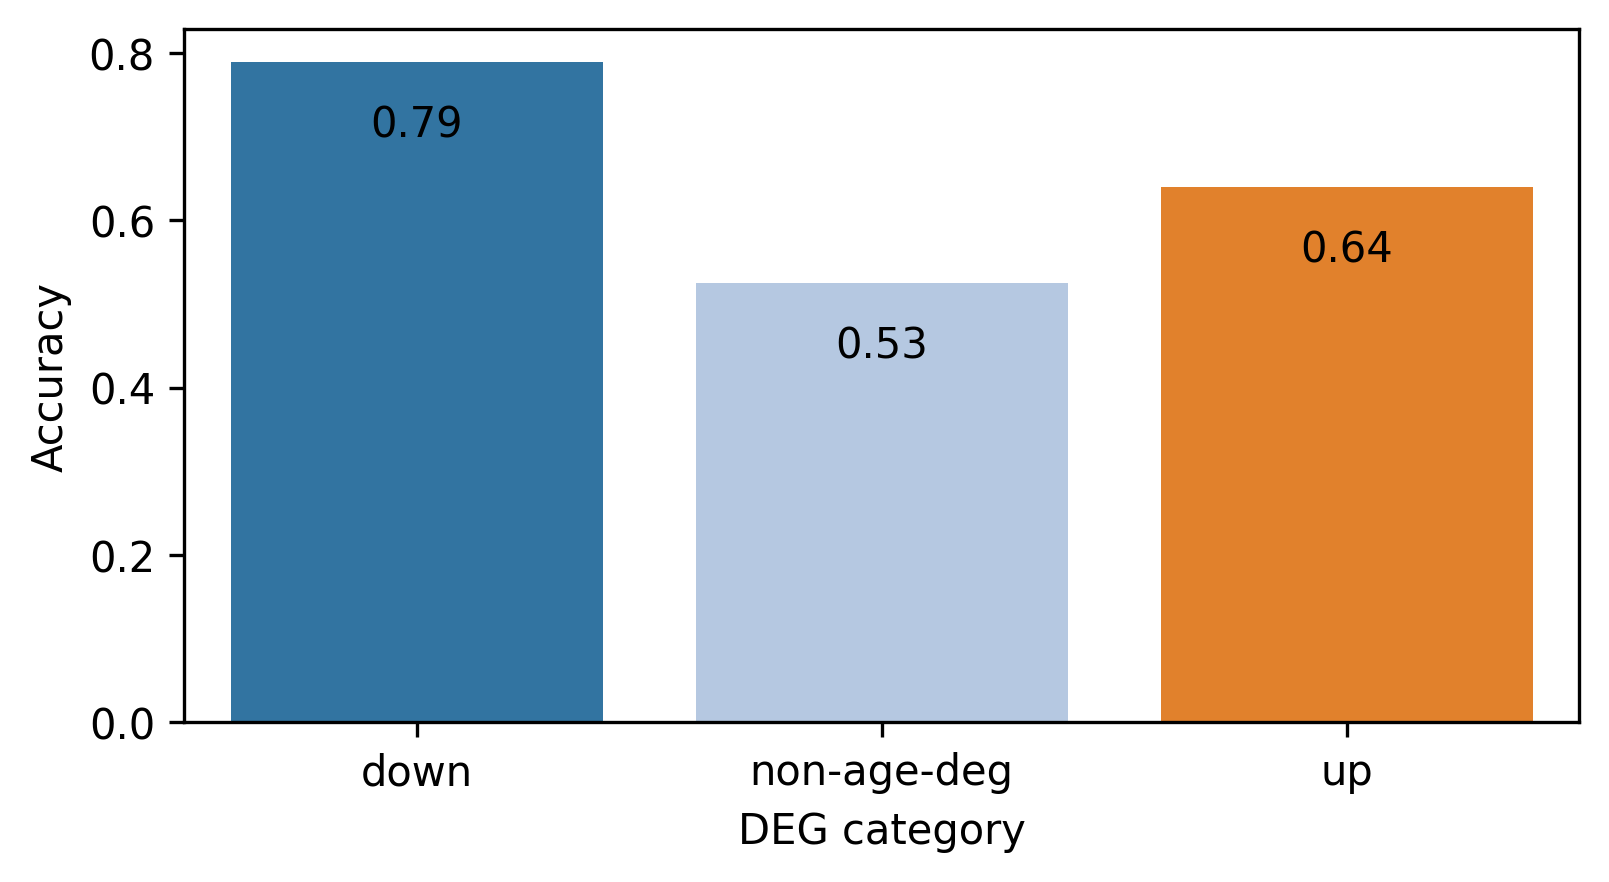

In [15]:
# make a barplot
fig, ax = plt.subplots(figsize=(6, 3), dpi = 300)
sns.barplot(x = toplot.index, ax = ax,palette='tab20',
            hue = toplot.index,y = toplot.values)
# change xticks label as down up and non-age-deg
ax.set_xticklabels(['down',  'non-age-deg', 'up',])
# set xlabel ad DEG category, y as accuracy
ax.set_xlabel('DEG category')
ax.set_ylabel('Accuracy')
#remove the egend
ax.get_legend().remove()
#label accuracy
for i in range(len(toplot)):
    ax.text(i, toplot.values[i]-0.1, round(toplot.values[i], 2), ha = 'center', va = 'bottom')